In [4]:
import detectron2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from utils.make_dataset import *
from utils.transforms import *
import cv2
from skimage import data, img_as_float, util
from skimage import exposure
import glob
import os
import re
import json
import numpy
from PIL import Image, ImageDraw
import torch
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultTrainer

Populating the interactive namespace from numpy and matplotlib


## Make 1st part of dataset

In [5]:
annotation_path = 'segmentation/bone_marrow_p1/annotations.json'

with open(annotation_path) as json_file:
    annotation_data = json.load(json_file)
print('masks: ',len(list(annotation_data.keys())))
filenames_list = glob.glob('segmentation/bone_marrow_p1/images/*.png')
print('images: ', len(filenames_list))

masks:  108
images:  390


In [6]:
seg_dataset = []
index = 0
for file in filenames_list:
    png_name = file.split('/')[-1]
    if png_name in list(annotation_data.keys()):
        element = {}
        orig_image = Image.open(file)
        width, height = orig_image.size
        img = Image.new('L', (width, height), 0)
        instances = annotation_data[png_name]['instances']
        for instance in instances:
            polygon = instance['points']
            ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        element['mask'] = numpy.array(img)
        element['path'] = file
        element['image'] = orig_image
        index += 1
        seg_dataset.append(element)

In [7]:
inverse = [44, 12, 20, 22, 34, 35, 57, 59, 63, 76, 82, 83, 101]
light = [3, 6, 14, 42, 35, 39]
throw_away = inverse + light
dec_seg_dataset = []
for i, item in enumerate(seg_dataset):    
    if i not in throw_away:
        dec_seg_dataset.append(item)        
seg_dataset = dec_seg_dataset

i = 2
img = np.array(seg_dataset[i]['image'])
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(img)
plt.show()

mask = array(seg_dataset[i]['mask'])
figure(figsize=(8, 8), dpi=80)
img[mask==1,0] = 255
imgplot = plt.imshow(img)
plt.show()
print(seg_dataset[i]['path'])


## Make 2nd part of dataset

In [8]:
images_list = glob.glob('segmentation/bone_marrow_p2/*.png')
print('images: ',len(images_list))
jsons_list = glob.glob('segmentation/bone_marrow_p2/*.json')
print('jsons: ',len(jsons_list))

images:  462
jsons:  421


In [9]:

for filename in jsons_list:
   
    element = {}
    pl = filename.split('/')[-1].split('.')
    img_name = pl[0] + '.' + pl[1]
    element['img_path'] = img_name
    orig_image = Image.open('segmentation/bone_marrow_p2/' + img_name)
    width, height = orig_image.size
    img = Image.new('L', (width, height), 0)
    with open(filename) as json_file:
        dict_info = json.load(json_file)
    instances = dict_info['instances']
    for instance in instances:
        if instance["type"] == "ellipse":
            shape = [(instance['cx'], instance['cy']),(instance['rx'], instance['ry'] )]            
            ImageDraw.Draw(img).ellipse(shape, fill =1, outline =1)  
            #print(index)
        if instance["type"] == "polygon":
            polygon = instance['points']        
            ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
            

    element['mask'] = numpy.array(img)
    element['path'] = file
    element['image'] = orig_image
    index += 1

    seg_dataset.append(element)

In [10]:
len(seg_dataset)

510

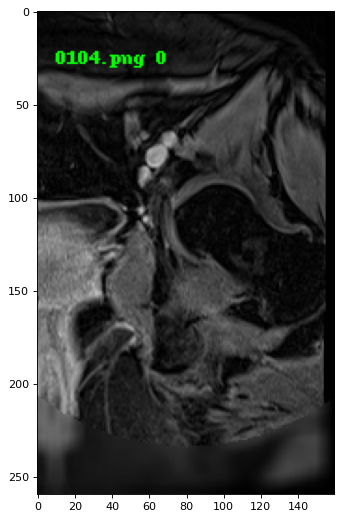

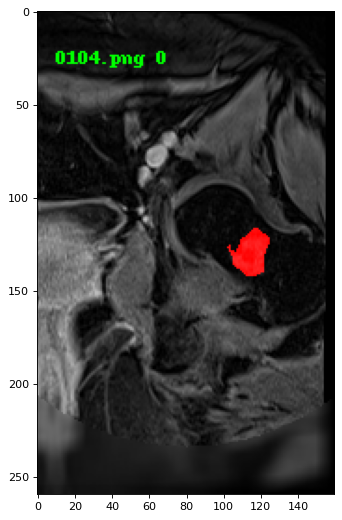

In [11]:
i = 416
img = np.array(seg_dataset[i]['image'])
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(img)
plt.show()

mask = array(seg_dataset[i]['mask'])
figure(figsize=(8, 8), dpi=80)
img[mask==1,0] = 255
imgplot = plt.imshow(img)
plt.show()

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
predictor = DefaultPredictor(cfg)

Loading config /home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/detectron2/model_zoo/configs/Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [13]:
def predict_box(image, projection):    
    
    if projection=='cor':       
        #image = np.stack((image, image, image), axis=-1)
        print(image.shape)
        #image = np.moveaxis(image,-1, 0)
        #print(image.shape)
        predictor = DefaultPredictor(cfg)
        outputs = predictor(image)  
        try:
            pred_boxes = outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0]  
        except:
            return None
            
        print(pred_boxes)
    else:
        pred_boxes = None
    return pred_boxes

In [15]:
cropped_seg_dataset = []
for item in seg_dataset:
    cropped_item = {}
    box = predict_box(np.array(item['image']), 'cor')
    if box is not None:
        cropped_item['image'] = square_crop(np.array(item['image']), box)
        cropped_item['mask'] = square_crop(np.array(item['mask']), box)
        cropped_seg_dataset.append(cropped_item)  
    else: 
        continue
print(len(cropped_seg_dataset))


(272, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 76.16931  86.64259 182.51859 206.1396 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.51081  92.52539 254.76028 269.17972]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.679943 142.2839   227.62245  329.6333  ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 37.713024 128.80997  118.857025 220.51662 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 17.87423 140.03983 120.77935 260.48624]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[117.24517 107.45731 280.34332 282.39914]
(640, 356, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 88.63892 242.1407  246.20673 418.26605]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 60.738243 124.84005  261.47015  329.2447  ]
(384, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 82.54436 148.92412 175.62527 255.82935]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[102.41924  99.62744 253.86017 263.735  ]
(384, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.85598 144.96703 148.73535 249.42488]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[106.824104  87.27624  284.43536  282.98798 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 64.4453  171.81544 158.22067 285.1348 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[124.32849 104.26467 285.87155 295.01883]
(264, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 70.99187  93.00046 155.85747 190.4045 ]
(768, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 76.4858  277.44604 280.12915 515.6078 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[117.916466 106.60998  290.30908  291.08237 ]
(270, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 76.16256   57.732944 178.52974  171.57954 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 49.661755 113.049164 248.79568  325.35056 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.73054  93.82635 181.54903 215.25328]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[154.95563 132.74045 321.38675 303.23682]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.93378 110.10523 201.95726 243.53233]
(270, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.595505  79.25288  163.77708  193.07527 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 47.632812 192.2734   147.5842   315.61365 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[103.44798   89.863625 259.07138  272.27173 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 45.42905 111.22892 226.95087 317.4122 ]
(640, 356, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[108.40253 248.50273 264.66406 433.33792]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[103.42692  91.68348 261.52893 276.06482]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[111.51214   55.050365 246.01245  212.04173 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 77.625984 142.5257   248.52661  333.72495 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 73.557434 175.75577  161.24013  292.1833  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 47.07276 199.56818 179.19284 354.5915 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.343925 172.69104  156.17336  290.70657 ]
(256, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.85162  68.3977  183.44156 195.68556]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 85.63109 192.35214 219.95969 336.4138 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 54.078148 103.04095  183.04793  245.66277 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.84963 103.40062 187.61739 232.40234]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[110.27548 108.96069 260.57916 277.02765]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 24.398636  71.01897  119.04223  188.01607 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 62.239117  68.867035 179.11418  191.1652  ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.530586 181.22202  165.00157  303.31003 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 87.31841 116.0369  197.61995 235.05132]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 80.03618  76.67228 253.93652 264.28247]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 78.34197  91.72621 196.08333 229.30368]
(270, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 19.317225  57.02733  117.45043  174.68901 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[115.44704 107.44617 270.08505 286.42593]
(306, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.17991 105.4345  156.71059 207.48956]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 54.126904 123.14788  155.10735  232.98203 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.941376 168.18495  203.09657  311.376   ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 81.337135 184.53366  211.77061  335.86948 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[137.64734 106.41507 323.243   304.0942 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[105.95947  98.02967 261.95386 267.6151 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[142.3995   88.3719  310.5198  269.77588]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 94.16237  118.297356 247.20808  284.63885 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[134.5379   99.08522 289.15393 303.4994 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[134.151    99.564   298.60336 269.4474 ]
(256, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.253193  58.71268  189.18     206.26785 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 42.08196 115.76598 242.5414  339.81354]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 98.44125 120.88167 269.59406 307.31583]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 86.47746 135.07034 246.89601 319.85593]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 69.78373 106.78671 180.0997  223.82307]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 86.03433  92.50716 268.62    281.6516 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.566345 120.832275 226.43762  305.76813 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[134.25269 112.74631 316.56503 311.6036 ]
(306, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 52.90933 112.0108  143.54512 219.38179]
(416, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 37.643047 169.60104  168.85387  312.35425 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 79.707184  98.07771  189.08684  221.90169 ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[105.32754 250.59702 255.12802 435.538  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[119.336525  80.74195  306.37387  289.97824 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.51328   81.776085 257.97345  271.61343 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.98378  98.52782 263.9841  277.54865]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  1.9585129 245.59273   161.04706   497.6199   ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.17003  75.46245 291.73117 280.5134 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[112.45153  86.13581 264.76587 264.94547]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.405304 173.68007  164.58319  308.39484 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.340645 171.30902  161.98218  287.4256  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 49.862907 162.90947  184.32     313.44135 ]
(384, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 77.328064 147.52312  174.7299   258.4075  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.45118 194.90948 211.40405 332.3772 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.91735 101.13892 179.52754 236.5179 ]
(272, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 73.9967   82.30508 186.77235 202.13243]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 19.522167 161.69827  133.04309  299.93515 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[118.790726  91.94898  274.12405  268.061   ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 45.28761 338.9824  235.37852 556.07   ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[107.352135  88.31376  279.0505   276.52737 ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 39.91275  126.954666 120.31689  228.923   ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 72.631775  88.818436 187.58879  223.09058 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.469864 132.95656  187.57588  273.58585 ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  1.0982485 131.99086    82.89418   256.8431   ]
(416, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 90.00482 161.83923 214.0198  284.85876]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 59.347805 147.35902  226.84853  332.9752  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.74972 106.12864 182.72757 226.33003]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.094215 100.72222  161.02066  210.90999 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[142.6275  123.19933 319.41663 315.52188]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 39.77781  108.98757  108.235306 187.29285 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[137.8744   97.04291 296.5149  267.97955]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.86048 176.40575 160.95778 290.32013]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 77.3908  135.34845 242.8386  319.22528]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.814186 124.229996 252.01057  297.0419  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.036224 109.48239  258.23303  278.47098 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 76.61729 106.54664 191.23665 241.2145 ]
(256, 128, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 43.760406  84.8161   115.62651  168.30286 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[125.71195 104.05055 284.753   289.802  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 83.89422  81.63088 261.00708 276.49698]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[111.83355  99.95588 264.66736 276.8844 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 59.154724 195.59454  175.49132  334.3789  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[125.78695 104.01796 284.82922 290.06696]
(306, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.14519 105.7037  158.7501  211.90955]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[114.40438  90.61395 269.47726 275.47363]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 41.312504 120.813416 213.1532   314.48654 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 70.28427 136.97453 243.53838 332.86078]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[120.40826  103.531235 284.514    284.402   ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 80.14856  76.45509 253.84065 264.25034]
(480, 240, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 45.130745 200.25124  148.75052  316.18243 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 78.85934 145.68849 179.40768 265.2017 ]
(540, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 92.14354 110.0503  267.02814 308.7345 ]
(256, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.39984   67.606384 183.18243  196.27032 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 97.8749    89.579796 255.23193  269.50977 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[139.1856  104.25769 312.71442 284.58633]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 93.193825  94.99119  188.456    209.79254 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 25.077168 138.47926  127.93294  261.02356 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 50.183304 189.18304  148.52242  316.6749  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.64547 182.42412 183.95212 298.00754]
(480, 240, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


(640, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  1.9662728 288.88715   137.35176   470.72025  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 60.439575 178.11063  165.40569  303.53256 ]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 32.273632  77.20873  223.98705  290.6251  ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[109.72702 231.8646  310.8089  499.09592]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[112.65457 113.43667 263.08102 273.32574]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.17884  120.268936 159.43468  234.56557 ]
(540, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[125.718925 112.82438  288.55035  281.5715  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 60.71041  118.894165 221.02684  321.66684 ]
(260, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 12.525931  87.740135  94.250145 173.06033 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 62.50884 175.50153 157.10477 286.02484]
(384, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 58.35628 151.08638 153.8749  251.82816]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[139.82396   88.860756 306.08063  275.4898  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.954815  84.15615  170.60487  209.74316 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[135.14479 119.43516 299.88223 311.15735]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.259476  93.788635 173.72845  235.20676 ]
(640, 356, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 87.47812 246.41856 244.51295 416.62024]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[129.5606  109.64763 307.30603 293.69586]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 61.461864 104.716    178.69434  246.2144  ]
(640, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[119.45057 180.84431 252.14801 363.6414 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[111.81688 107.89683 255.98282 269.4993 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[117.872246  72.98813  312.24002  281.88913 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[126.77199  85.99385 298.09442 277.78564]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 44.62548 154.7949  129.61179 249.37776]
(640, 356, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[101.58599 252.78516 263.79544 436.7042 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 24.061136 153.0479   118.20239  269.62698 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.62514 122.28892 254.31659 331.01535]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.57872 106.02408 168.56827 234.41586]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 73.50073 158.06923 155.85553 258.8779 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 70.497826 116.31807  182.71774  262.9974  ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  3.3413107 125.47508   120.32443   285.47018  ]
(256, 128, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 20.021654  86.756775  78.971466 157.33711 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[152.85071  107.949684 331.40747  293.56418 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.524765  81.67903  257.95212  271.605   ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 98.03007  93.46597 192.46758 217.35081]
(640, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  3.4882812 207.44489   141.10594   390.80878  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[148.98146 136.88976 294.32162 299.84836]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 61.470943 153.22252  148.6766   246.32394 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.35506  89.04346 191.64987 224.22154]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 74.000305 111.75959  176.13832  233.35349 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 74.94686 100.20817 191.1947  222.48593]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 97.82854   62.635876 259.46393  272.80127 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 59.9262   125.047264 255.57356  335.72845 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[110.79721  89.01609 259.64874 262.3885 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 60.670418  67.03887  175.07433  200.2452  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 69.605896 200.22844  183.1869   332.2455  ]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 87.91441   59.515835 238.96484  253.72978 ]
(560, 280, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.41765 214.41272 190.89264 377.67847]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 86.208824  91.346344 181.33356  200.30644 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 10.594198 122.834206 122.65639  271.9151  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 91.99957  90.20191 252.2791  271.88553]
(256, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.22659  66.2961  181.41086 198.39267]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 87.303635  66.54604  300.14536  311.50272 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[149.4128  102.15167 314.80215 287.35715]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.78346 125.724   171.23788 254.5404 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[125.73366  112.926506 292.231    285.76306 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 70.128624 128.44618  187.53947  267.95395 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.390675 135.75389  243.98483  344.7316  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 60.604115 126.045906 251.43498  334.30856 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.168564 163.91115  196.385    306.27322 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 75.37147  94.45612 196.14017 229.87292]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.44543  119.968315 257.3583   333.9996  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 54.33507  94.40164 186.65709 238.2741 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 85.838875   8.585676 246.65065  171.9097  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 78.15447 143.92331 254.25659 333.29706]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 91.72578 182.47954 188.10281 308.76117]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 98.799255 110.05513  261.5048   294.22025 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[108.60539   89.403625 272.84396  271.87238 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 64.074905 194.12631  187.89935  343.06845 ]
(288, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.90429  85.43498 130.30026 167.93452]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 50.27803 145.50078 115.43047 224.52325]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 53.670204 122.26525  237.49156  339.41953 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[132.39067 109.04143 316.75815 298.30804]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 52.814316  81.709526 169.69798  217.14204 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[117.89793 110.40093 279.84848 287.07266]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.28942 176.27988 157.98874 285.9587 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 35.806362 160.19742  126.32881  273.792   ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[137.64717 106.41557 323.24463 304.09442]
(640, 356, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 88.7474  242.32175 231.64934 405.8356 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 50.79482 107.8255  214.66058 297.3061 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 13.6887865 118.910286  116.35359   251.15996  ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 48.351868 120.88405  123.26849  213.76134 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[140.52774 126.15603 300.57092 304.97675]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 11.184106 128.08098  126.0249   274.6967  ]
(384, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.089203 145.53606  150.35216  245.61296 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 54.097366 114.22364  250.29391  334.00946 ]
(288, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.55111   89.074234 131.30502  176.6768  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 84.68781   97.963234 189.90538  220.32726 ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 38.916588 152.81927  110.07703  229.80319 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 59.929058 111.542274 178.28275  250.4352  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.641235 123.59768  234.88817  313.104   ]
(270, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 21.25648   58.971233 117.49765  173.95564 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.4241   98.33982 165.35855 217.26299]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.903442 103.857635 168.49638  238.68364 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 81.2604  165.65265 182.99745 289.67844]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 84.63635 198.80772 203.13855 343.33838]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[157.90921 142.16217 295.88065 307.78137]
(560, 280, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.99867 212.74948 200.09166 375.56818]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[126.266014 104.167496 287.90955  295.71472 ]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 97.13508  65.87997 234.21475 217.42398]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.68457  122.029366 254.22884  337.22412 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 86.43543    6.302798 253.57564  180.56624 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 16.626978 147.16641  116.971504 274.20145 ]
(384, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 79.89092 147.91388 172.35605 253.05081]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 81.28331 113.58906 186.60172 240.53749]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  5.9075985 132.85002   121.45576   285.7496   ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[124.78125 100.08786 283.15393 296.53036]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 37.64088  82.658   219.39336 287.50854]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 61.909473 162.38696  187.00864  306.54172 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[102.967186  93.679504 296.12262  297.58923 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  6.190096 132.60359  106.189125 283.84006 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[106.931465  94.75156  283.3155   285.96408 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 98.69442  93.27172 285.95248 308.34988]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[112.71366  78.32236 302.5286  278.13608]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  2.260076 258.35434  159.24466  481.2766  ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 62.725704 174.1028   155.94514  290.04398 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 96.8252   116.065094 196.84418  241.48228 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 50.718983 118.63682  237.58122  343.2524  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[138.94002 108.82649 291.26672 300.17624]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.12374  96.28812 249.55821 260.48407]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[103.39237  126.018425 246.77678  297.9419  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[134.11874   99.548584 298.59818  269.45078 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[101.07119   96.676926 252.71475  267.42245 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 85.192696  75.83514  200.56607  203.1168  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.998795 100.37111  163.48315  213.64977 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 58.776318 144.50636  167.56874  272.8269  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[112.37673  98.89293 262.17532 267.1497 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 53.381355  58.69863  192.23438  208.27568 ]
(416, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 64.37134 173.27124 173.5741  295.62003]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.17446   91.273125 263.75217  284.36188 ]
(640, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.63819 290.4386  254.95811 486.07608]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 81.16571 128.9525  194.17659 260.02234]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 64.68365 174.30208 165.68694 292.53946]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 79.480415  96.410484 198.17859  227.02473 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 97.300705  89.67144  254.70937  269.42462 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[119.43261  96.40665 269.73715 270.5445 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.432945 159.84998  157.0059   265.37527 ]
(256, 128, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 35.10931  82.296   107.84689 167.17264]
(306, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.412094 106.45935  159.23633  211.08737 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.80404 145.91313 224.76283 331.8764 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 96.25624    5.841936 254.28485  161.94957 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.456184 118.67789  223.41537  312.799   ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.34551  90.39207 194.4498  224.13612]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[113.61018 110.48597 274.4535  288.69092]
(264, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 45.27838  90.969   138.27487 195.8061 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 79.40813 121.23985 193.77252 247.92809]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 73.889435  94.41023  188.18124  228.5705  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[139.02745 109.02961 324.34552 303.76578]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.16626   91.000946 263.8902   271.19598 ]
(306, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 52.424183 110.87545  143.42412  219.5221  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[131.32948  91.83604 305.45038 273.6574 ]
(288, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.651527  88.2676   134.16187  178.83696 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.066605 157.60017  152.74892  262.62085 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.251   179.45973 167.04134 309.981  ]
(306, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 53.557102 111.22787  143.16484  213.91142 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.27614   75.208145 291.73718  280.446   ]
(640, 356, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[116.37225 247.72661 275.2481  430.46744]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[114.40491   55.364094 243.7122   198.8417  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.71313 125.93733 246.22786 293.27747]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 43.37119 119.57913 240.60406 333.16312]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.94536 248.68967 254.44041 449.7049 ]
(256, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.896145  59.284637 190.30165  206.22366 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[140.09262   59.473835 283.9245   202.83208 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 92.331726 103.60439  262.0329   294.82492 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.76142 128.87387 173.85622 256.53696]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 87.73134 139.5082  249.33769 323.9584 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.16581 172.69551 161.63995 281.3407 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.25321  92.88291 193.22359 220.70259]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.996212 153.46964  160.3759   261.0429  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[113.08418  106.335915 282.4694   302.1529  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.91268  96.61043 162.16411 214.29243]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 60.900307 173.43542  155.93573  291.40485 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 86.45286  78.09759 198.85725 204.30832]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.312336 131.89714  246.55986  343.9777  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[101.901665  85.464714 270.0321   269.91565 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[103.02874  77.23637 286.96582 271.0023 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 98.44178  120.887665 269.59482  307.31284 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 19.589357 158.51358  135.70358  300.66724 ]
(264, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 74.04482  92.90294 156.31778 191.22612]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[110.79868  81.69544 283.88092 275.68665]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[125.306274 112.95085  292.02072  285.64984 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.83382 131.70285 209.93546 311.74405]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 19.522167 161.69827  133.04309  299.93515 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.42996 139.07855 177.83247 282.61243]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  8.9385605 126.96106   119.693474  261.7285   ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.55831 171.25882 163.96213 291.48712]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[105.70856 111.64806 284.75015 301.54358]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[154.5628  128.94925 316.13553 303.84247]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 64.690544 176.81764  165.70316  295.9343  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 82.822296 190.32796  220.26764  337.10126 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 91.478195 180.28252  186.36734  303.29602 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.783455 138.38733  227.3798   304.65674 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 49.635006 113.037735 248.79094  325.3536  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 87.10382 204.29991 199.66183 340.7606 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 87.76856 126.19393 250.64287 299.5613 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[108.76395  100.906334 273.19843  285.39398 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[103.926704  91.4936   261.8215   275.7709  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[125.96238  71.28072 315.74997 277.03552]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 93.69903   93.724686 252.63184  267.6016  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[131.42116  96.2881  273.96088 262.24487]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.61811  96.88144 260.38852 273.81573]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 76.51127 115.62706 186.92665 242.85335]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  3.9517326 254.12715   164.23296   505.47122  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.190807 125.55211  207.76538  296.29846 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.00321 162.53221 165.35297 291.78122]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 53.939346 107.59114  174.14168  242.2775  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[110.26464 102.01918 283.11752 302.9452 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[122.27345  102.423485 257.8332   254.03474 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[114.01958  91.2152  269.2621  267.30814]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  3.9520547 254.12639   164.23265   505.47162  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.927    65.48171 188.2002  190.53708]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 64.47776 114.83984 247.08023 316.58093]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  5.4558907 116.06375   111.20588   257.7602   ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 84.895096 183.27336  183.97925  304.67297 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 60.907745 153.69073  170.52974  283.80798 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[151.71298 140.0761  317.701   325.22626]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[100.14302  80.98958 256.50372 260.69418]
(260, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 22.366581  91.48049   92.82861  170.08032 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 10.390794 115.96527  118.303764 252.5649  ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 62.80871 173.44707 160.5636  291.63995]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 59.26874 140.77837 233.89514 331.75424]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.85467  69.95446 180.25597 189.56184]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 76.002464 122.008804 192.5028   262.1014  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[118.87087 100.52122 285.18552 295.22302]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[129.61813 105.17804 287.89398 294.33798]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[121.83317 105.58655 258.06488 259.22498]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 74.8026  136.05307 234.6314  320.17456]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 23.207561 124.235016 121.40547  249.42221 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[118.10085 105.2366  271.83252 274.3596 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 84.35673 190.53816 215.96533 333.78958]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 72.54031 106.46028 174.26646 230.41183]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[107.29637  87.60025 295.9296  303.91757]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 46.842537 113.59221  243.71584  328.22305 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.38156 181.09277 173.33095 311.60852]
(416, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 37.320824 175.50896  166.84071  313.5598  ]
(560, 280, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.43842 210.05765 212.28195 355.9181 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.51489  86.97954 280.82895 282.97382]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.43745  65.14249 265.24786 260.26392]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[140.28586  127.637344 299.95807  302.89194 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[140.41869  82.41743 307.01373 260.05276]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[101.059944  96.78004  252.68704  267.27966 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 53.17604 140.1256  231.51268 336.91544]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[122.68792  75.57615 309.12762 287.50073]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 62.48424 183.35522 170.96852 304.89954]
(256, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 51.794693  59.006844 187.9184   206.53925 ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 43.453865 150.5018   112.243164 228.8443  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 50.858803 102.67102  248.97768  326.37762 ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 78.879524 226.43323  218.29202  408.6625  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 82.72044  92.0784  180.52159 201.41492]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.03335 121.54404 166.39526 239.20123]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  1.6646876 243.88216   159.2566    502.88354  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.14565 195.83475 185.20888 332.21674]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[148.50343 135.79678 295.9094  299.0059 ]
(480, 240, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 58.85589  109.145584 172.21362  239.15085 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[144.00917  94.97118 318.08762 291.52136]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[134.5468   97.21736 302.41977 275.86362]
(384, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 80.1552  147.7477  175.12273 255.5114 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[114.234024  96.16489  298.75922  296.96094 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 75.3713  120.19965 176.71147 258.54492]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[105.2005  100.01047 266.281   273.7552 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[129.1288  105.15441 281.4017  292.984  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 77.53578 207.06665 194.03558 339.61453]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.81786 205.59987 189.00546 340.8893 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.64515 113.11634 243.27357 312.3803 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 79.36887   99.242325 197.06061  239.27556 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.921745 128.50069  174.53905  261.075   ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 46.382763 196.77466  179.10942  341.98468 ]
(270, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 25.566017  59.179207 118.64169  171.27711 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 31.138006 135.70107  230.01671  342.69208 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 84.29644  99.16791 197.01875 233.01982]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[122.226234  83.71261  290.0743   287.37033 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[131.2905  101.00511 290.20987 293.08884]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 61.142883  68.893425 178.64818  204.10783 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 78.9962  139.3795  188.55066 275.5561 ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 26.760323 123.742676 105.92999  220.98952 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 22.412605 173.9902   116.249596 302.29233 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 58.82778 176.18906 169.7289  308.07928]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 70.09123 105.19374 179.3153  226.89464]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 83.94348 136.31664 244.8677  322.38394]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[120.817505  96.02189  284.29276  281.99353 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 76.735115 111.762535 184.50742  243.08824 ]
(480, 240, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 32.15162 177.40187 144.99251 334.26965]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 64.58058 182.00452 168.4459  296.82904]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.34713 152.16434 175.91122 277.53253]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 45.053448 188.10246  148.94206  314.32343 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[135.59763  124.209724 317.05646  304.43134 ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[109.72702 231.8646  310.8089  499.09592]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 58.690002  95.57239  186.08014  239.22684 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.210625 194.82195  207.86116  331.57217 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[114.38708  99.16325 259.10397 255.19353]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 62.235054  68.01973  178.71223  191.8691  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[113.973885  80.489456 292.39526  273.96832 ]
(260, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 69.2618   80.2892  148.30487 165.43333]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 52.01192 121.58589 242.13266 333.73544]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 42.560318 115.30793  222.70425  311.0892  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 84.29353 132.86452 250.96631 327.7777 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 68.772255 133.15157  243.43013  317.4051  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[111.88246  73.6552  266.0837  246.72978]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 62.827526 172.09843  161.17747  290.3888  ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 73.873665 128.94019  179.51877  264.80988 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[141.03955 123.75322 300.5219  298.33804]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 71.63769 142.61983 246.99002 343.21307]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[109.43799 131.27592 274.2283  311.65753]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.287285 114.60281  241.90182  320.82034 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[110.8236   89.05516 259.68628 262.5518 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 28.142376 121.47148  125.03281  238.45164 ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[114.36316 245.32307 310.40375 482.46915]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[121.364975 106.28825  267.67352  268.0117  ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 46.1623  191.37866 177.78543 343.7492 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[145.82423 112.06827 323.16046 312.78397]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[107.04669  92.72989 268.6708  272.83063]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 41.86083 108.50575 111.16612 189.38802]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 82.696686 126.35139  193.3596   258.5331  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[119.17558  106.980515 285.08392  297.15027 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 45.911373 130.74734  237.35947  327.1948  ]
(270, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 72.93543  56.41404 176.17273 172.49449]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 50.00197 171.29593 181.63019 309.5045 ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.07016 235.02867 306.37766 494.45578]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.264153 131.1757   208.98146  317.98898 ]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 19.950733 150.824    127.95333  281.67548 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.70739  65.42447 185.93745 192.37283]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 77.84585 171.85677 201.66324 306.35788]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.086716 196.37076  183.10338  333.45667 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 79.250725 108.08549  192.55305  238.42537 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[105.773926  78.55936  297.88907  298.48425 ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 46.326633 118.264915 129.25575  208.3797  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[121.82485 110.82958 286.57727 283.12814]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 48.044598 188.32487  176.2184   326.47275 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 53.659462  56.446957 192.45586  212.37482 ]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[101.556114  68.31536  216.63902  195.07361 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 49.20799 165.40015 185.61844 314.25183]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[115.02026 139.11273 267.65393 309.2551 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.228   139.51721 223.21693 325.08673]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 91.01488   91.723976 255.81331  275.16794 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 55.66133 134.71568 233.70506 329.48895]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.33536 128.10727 227.03473 320.78745]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 56.405304 173.68007  164.58319  308.39484 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.49511 174.85127 156.82704 287.588  ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.28732 104.96213 178.14757 244.1324 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.973114 188.11356  214.65997  332.6201  ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[  5.8445725 256.73553   163.55641   496.39594  ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 39.38495  104.90821  114.565704 190.11353 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 60.777527 189.36325  179.4585   331.23975 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[134.25269 112.74686 316.56192 311.60605]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.11731 139.68681 173.15096 262.09833]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 12.369303 137.94775  111.78036  261.89883 ]
(512, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 64.43287 190.89514 184.108   331.1976 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 59.642387 117.425385 229.22386  305.57306 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 51.97514 118.50959 216.26877 303.25076]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 73.634926  97.21498  191.358    224.78896 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 69.15979 103.33359 165.24464 211.72234]
(560, 280, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 78.43665 213.95026 201.96875 363.6056 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 86.20541 105.16682 205.16518 238.85603]
(384, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 25.014141 162.95125  126.91158  296.20746 ]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 63.577785 172.70885  154.53589  291.10104 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 98.312355 118.73615  195.86066  242.25708 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 98.18371 123.46503 269.5968  307.39594]
(416, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 90.214516 158.28874  213.86058  291.21796 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 57.52095 106.79129 172.10806 246.07742]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[113.06473  80.2911  295.02542 278.46982]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[149.39705  110.217766 323.38364  311.5573  ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 89.61959     4.9472165 253.52267   178.40411  ]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[110.79949  53.56222 241.36446 205.76147]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[101.8493   79.22534 277.55365 269.43423]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 39.854122 106.13963  110.9079   189.64832 ]
(288, 192, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 53.409184  84.494194 130.09355  172.92722 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[106.41858  106.912254 253.77878  266.61554 ]
(260, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 62.479275  75.2542   151.6459   166.95755 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 99.049    98.82296 297.34232 309.3842 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 96.6926   95.49265 188.76096 209.37636]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 67.8585   94.92789 161.92484 221.57913]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 84.81345  79.92155 252.0357  267.6899 ]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 72.69878   93.941055 187.86226  227.05884 ]
(320, 160, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 32.03174  124.489494 110.87446  220.15622 ]
(256, 128, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 20.587255  93.67804   88.91801  168.80553 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[120.91333 110.28401 273.90228 282.0219 ]
(640, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[104.07016 235.02867 306.37766 494.45578]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[150.13535 128.3465  318.34872 309.34875]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 65.2086  171.55223 164.86421 295.53464]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[132.99867 121.45724 307.46976 311.04596]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 87.77071 104.70526 208.42819 244.41249]
(320, 320, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 84.28979  56.50818 259.91797 261.76157]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.16923 176.47081 158.43713 288.42575]
(448, 224, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 66.99182 173.59111 160.58171 285.53976]
(320, 256, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 58.470688 111.35195  179.14091  246.86179 ]
(384, 384, 3)


The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[ 44.013523 127.11606  199.5387   314.64706 ]
508


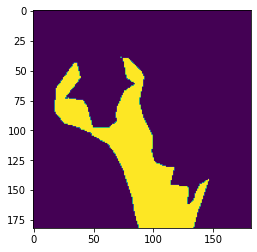

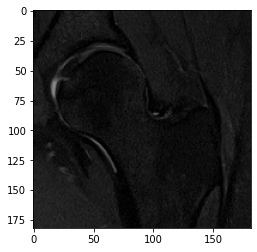

In [17]:
i = 24
plt.imshow(cropped_seg_dataset[i]['mask']) 
plt.show()
plt.imshow(cropped_seg_dataset[i]['image']) 
plt.show()

In [115]:

for i, item in enumerate(cropped_seg_dataset):    
    
    image = item['image']    
    mask = item['mask']    
    name = str(i)+'.png'
    mask_name = str(i)+'.gif'    

    outname_i =  os.path.join('segmentation', 'data','images', name)
    outname_m =  os.path.join('segmentation', 'data', 'masks', mask_name)
    #cv2.imwrite(outname_i, cv2.UMat(image))
    #cv2.imwrite(outname_m, cv2.UMat(mask))
    image = Image.fromarray(np.uint8(image))
    mask = Image.fromarray(np.uint8(mask*255))

    #image.save(outname_i, "PNG")
    #mask.save(outname_m, "GIF")


In [ ]:
[19,21,]

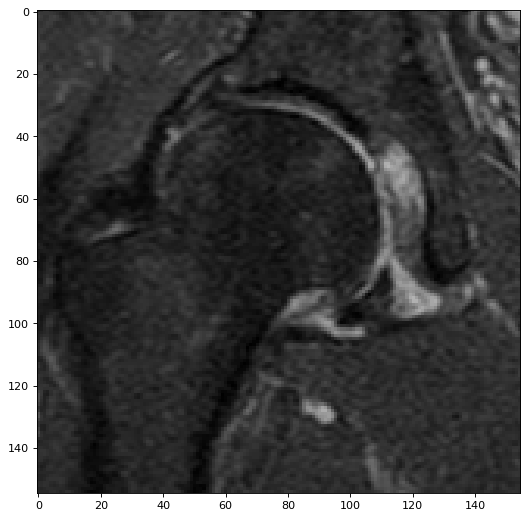

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x640 with 0 Axes>

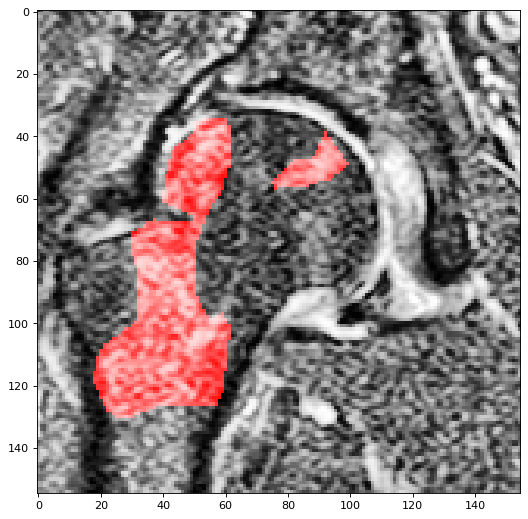

In [51]:
i = 31
img = cropped_seg_dataset[i]['image']
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(img)
plt.show()
p2, p98 = np.percentile(img, (5, 100 - 5))
        
img =  exposure.equalize_adapthist(img, clip_limit=0.03)
figure(figsize=(8, 8), dpi=80)
#imgplot = plt.imshow(img)
#plt.show()
mask = cropped_seg_dataset[i]['mask']
figure(figsize=(8, 8), dpi=80)
img[mask==1,0] = 255
imgplot = plt.imshow(img)
plt.show()